In [55]:
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
# Load data
df = pd.read_csv('merged_data_clean.csv', parse_dates=['Datum'])

In [57]:
df.head()

,Datum,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,id,Warengruppe,Umsatz,KielerWoche
0,2012-01-01,8.0,9.82,14,58.0,NaN,NaN,NaN,NaN
1,2012-01-02,7.0,7.44,12,NaN,NaN,NaN,NaN,NaN
2,2012-01-03,8.0,5.54,18,63.0,NaN,NaN,NaN,NaN
3,2012-01-04,4.0,5.69,19,80.0,NaN,NaN,NaN,NaN
4,2012-01-05,6.0,5.30,23,80.0,NaN,NaN,NaN,NaN


In [58]:
holidays = pd.read_csv('../0_DataPreparation/initialdata/german_holidays.csv', parse_dates=['Datum'])
holidays.head()

,Datum,Feiertag,Wochentag,Is_Holiday
0,2012-01-01,New year,Sunday,1
1,2012-04-06,Karfreitag,Friday,1
2,2012-04-09,Ostermontag,Monday,1
3,2012-05-01,Tag der Arbeit,Tuesday,1
4,2012-05-17,Mariä Empfängnis,Thursday,1


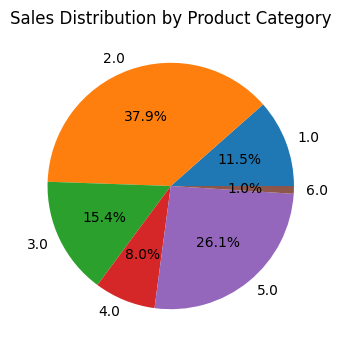

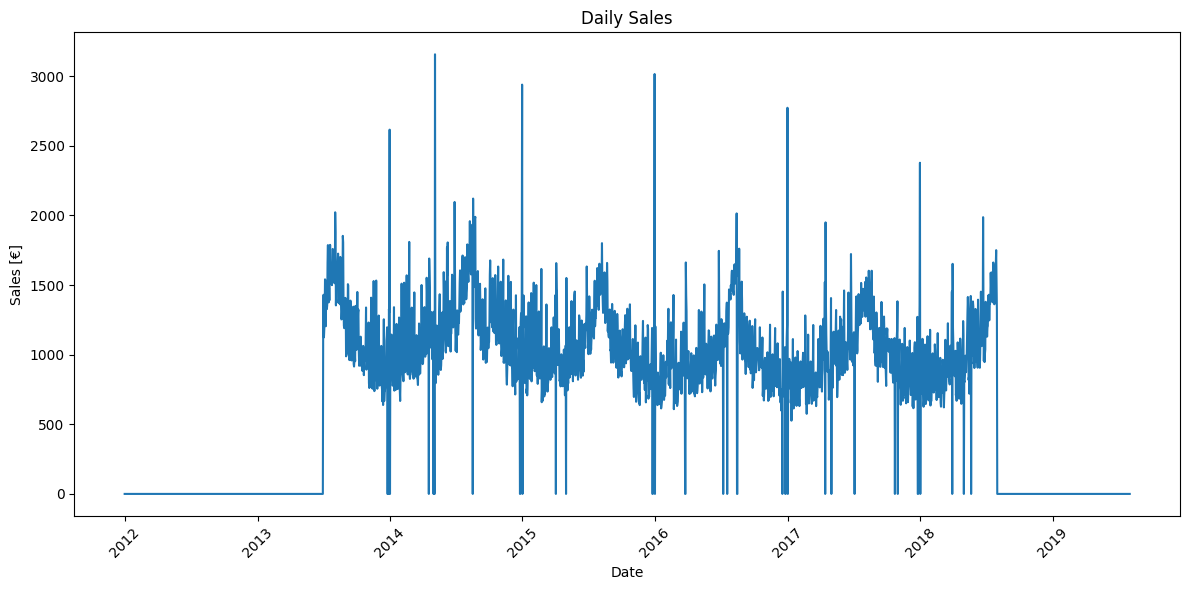

In [59]:
# PIE CHART - Sales distribution by product category
plt.figure(figsize=(4, 4))
sales_by_category = df.groupby('Warengruppe')['Umsatz'].sum()
plt.pie(sales_by_category.values, labels=sales_by_category.index, autopct='%1.1f%%')
plt.title('Sales Distribution by Product Category')
#plt.savefig('pie_chart_product_categories.png')
plt.show()

# Time Series - Daily Sales
plt.figure(figsize=(12, 6))
daily_sales = df.groupby('Datum')['Umsatz'].sum()
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales [€]')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('zeitreihe_umsatz.png')
plt.show()


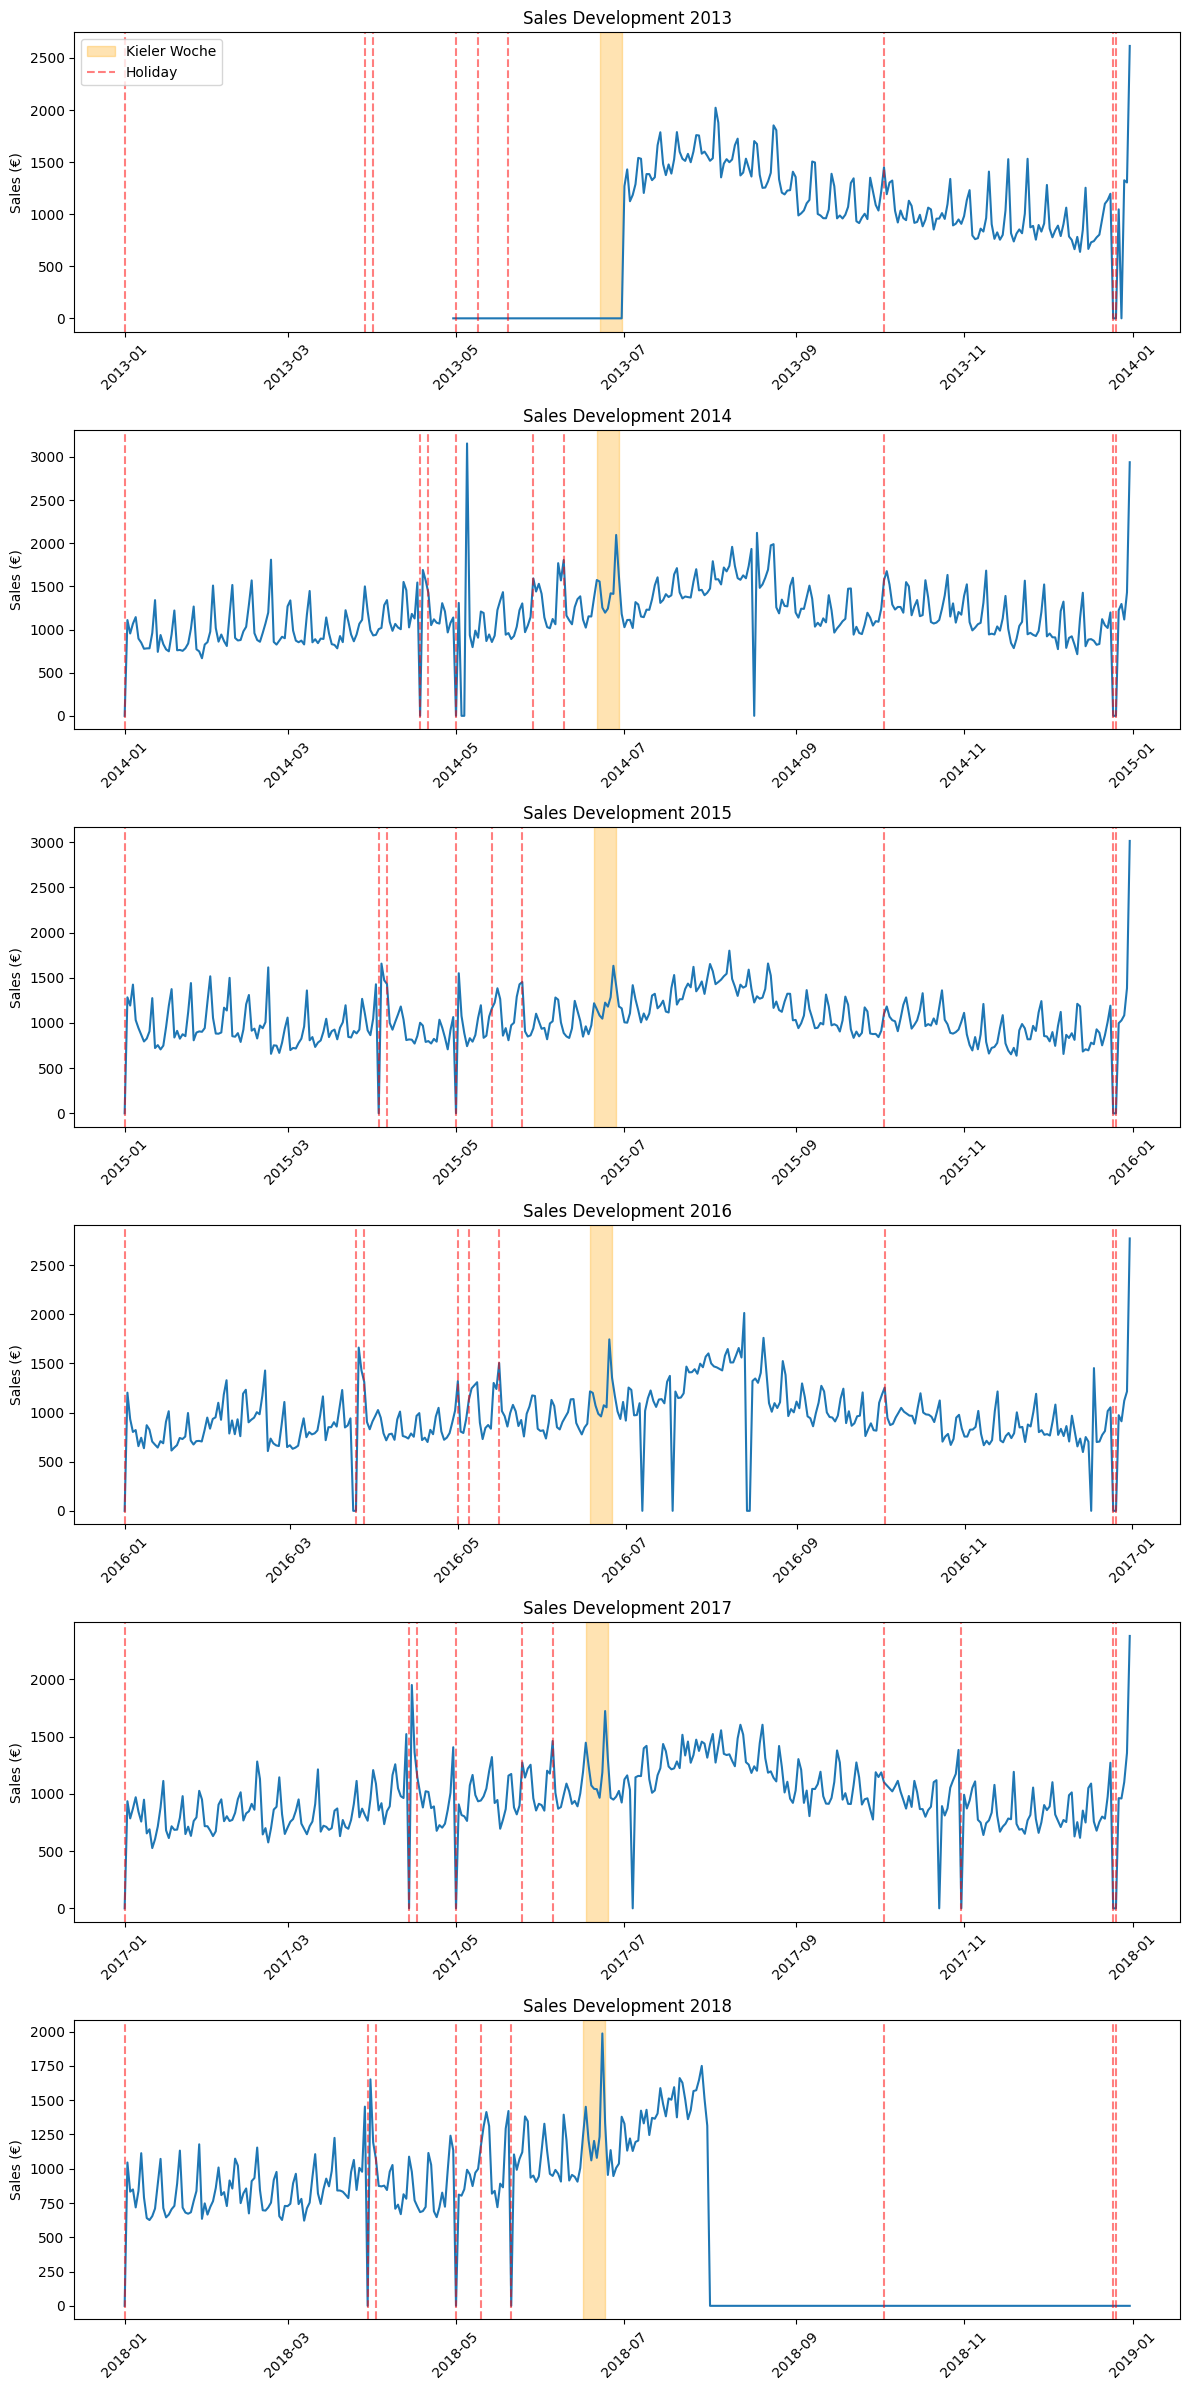

In [60]:
# TIME SERIES CHART - Daily sales by years with Kieler Woche and holidays highlighted

daily_sales = df.groupby('Datum')['Umsatz'].sum().reset_index()
daily_sales['Year'] = daily_sales['Datum'].dt.year

# Remove years 2012 and 2019
daily_sales = daily_sales[~daily_sales['Year'].isin([2012, 2019])]

# Get unique years
years = sorted(daily_sales['Year'].unique())
num_years = len(years)

# Get Kieler Woche date ranges per year
kiwo_dates = df[df['KielerWoche'] == 1].groupby(df['Datum'].dt.year)['Datum'].agg(['min', 'max']).reset_index()
kiwo_dates = kiwo_dates.rename(columns={'Datum': 'Year'})
kiwo_dates = kiwo_dates[kiwo_dates['Year'].isin(years)]

# Get all holiday dates
holiday_dates = holidays['Datum']

# Create subplots
fig, axes = plt.subplots(num_years, 1, figsize=(12, 4*num_years))
if num_years == 1:
    axes = [axes]  # For case when only one year is present

for i, year in enumerate(years):
    year_data = daily_sales[daily_sales['Year'] == year]
    axes[i].plot(year_data['Datum'], year_data['Umsatz'])
    axes[i].set_title(f'Sales Development {year}')
    axes[i].set_ylabel('Sales (€)')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Highlight Kieler Woche
    kiwo = kiwo_dates[kiwo_dates['Year'] == year]
    if not kiwo.empty:
        axes[i].axvspan(kiwo['min'].values[0], kiwo['max'].values[0], color='orange', alpha=0.3, label='Kieler Woche')
    
    # Highlight holidays
    year_holidays = holiday_dates[holiday_dates.dt.year == year]
    for holiday in year_holidays:
        axes[i].axvline(holiday, color='red', linestyle='--', alpha=0.5, label='Holiday' if holiday == year_holidays.iloc[0] else "")

    # Only add legend once
    handles, labels = axes[i].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if i == 0:
        axes[i].legend(by_label.values(), by_label.keys())

plt.tight_layout()
#plt.savefig('time_series_sales_by_years.png')
plt.show()

High Sale at New Years

In [61]:
# Find the day with the highest total daily sales per year

# Aggregate daily sales
daily_sales = df.groupby('Datum')['Umsatz'].sum().reset_index()
daily_sales['Year'] = daily_sales['Datum'].dt.year

# Find the day with the highest total sales for each year
highest_sales_per_year = daily_sales.loc[daily_sales.groupby('Year')['Umsatz'].idxmax()][['Year', 'Datum', 'Umsatz']]

print(highest_sales_per_year)

      Year      Datum   Umsatz
0     2012 2012-01-01     0.00
577   2013 2013-12-31  2615.41
702   2014 2014-05-05  3156.41
1307  2015 2015-12-31  3014.92
1672  2016 2016-12-31  2772.60
2035  2017 2017-12-31  2377.80
2209  2018 2018-06-23  1987.06
2389  2019 2019-01-01     0.00


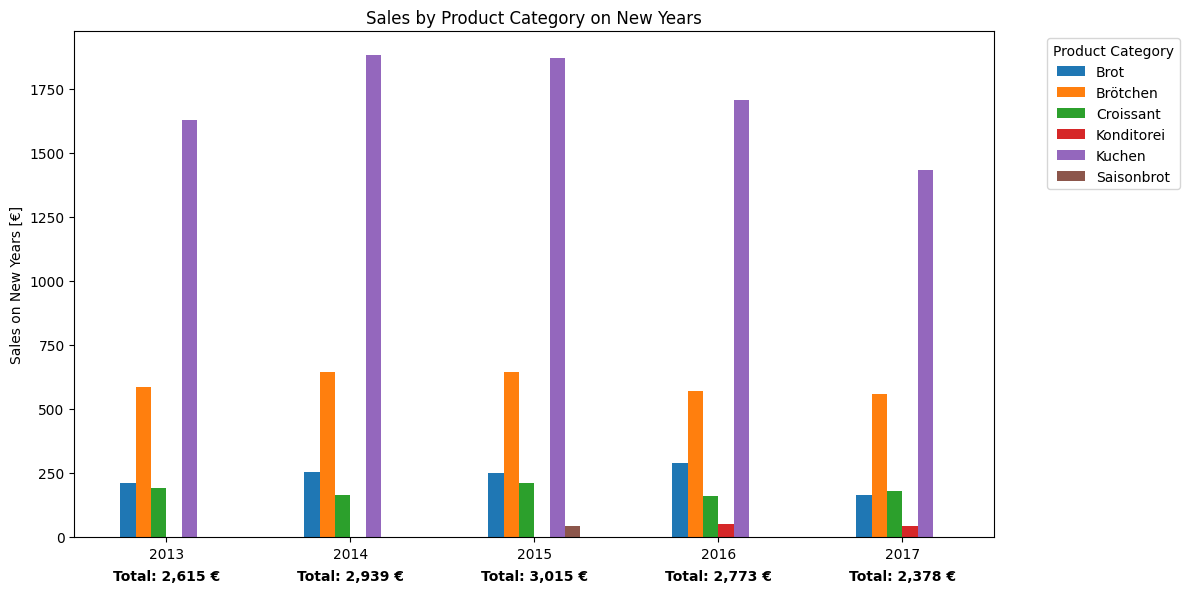

In [62]:
warengruppe_mapping = {
    1: 'Brot',
    2: 'Brötchen', 
    3: 'Croissant',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Saisonbrot'
}

# Find the last day of each year in the data
last_days = df.groupby(df['Datum'].dt.year)['Datum'].max()

# Filter sales for those last days
last_day_sales = df[df['Datum'].isin(last_days.values)]

# Group by year and product category, sum sales
category_sales_last_day = last_day_sales.groupby(
    [last_day_sales['Datum'].dt.year, 'Warengruppe']
)['Umsatz'].sum().reset_index()

# Map category codes to names
category_sales_last_day['Warengruppe_Name'] = category_sales_last_day['Warengruppe'].map(warengruppe_mapping)

# Calculate total sales for each year
total_sales = category_sales_last_day.groupby('Datum')['Umsatz'].sum()

# Pivot for better visualization
pivot = category_sales_last_day.pivot(index='Datum', columns='Warengruppe_Name', values='Umsatz')

# Plot as grouped bar chart
ax = pivot.plot(kind='bar', figsize=(12, 6))
plt.xlabel('')
plt.ylabel('Sales on New Years [€]')
plt.title('Sales by Product Category on New Years')

# Add total sales as description beneath each year
for idx, year in enumerate(pivot.index):
    total = total_sales.loc[year]
    ax.text(idx, -180, f'Total: {total:,.0f} €', ha='center', va='bottom', fontsize=10, color='black', rotation=0, fontweight='bold')

plt.xticks(rotation=0)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Influence of KiWo

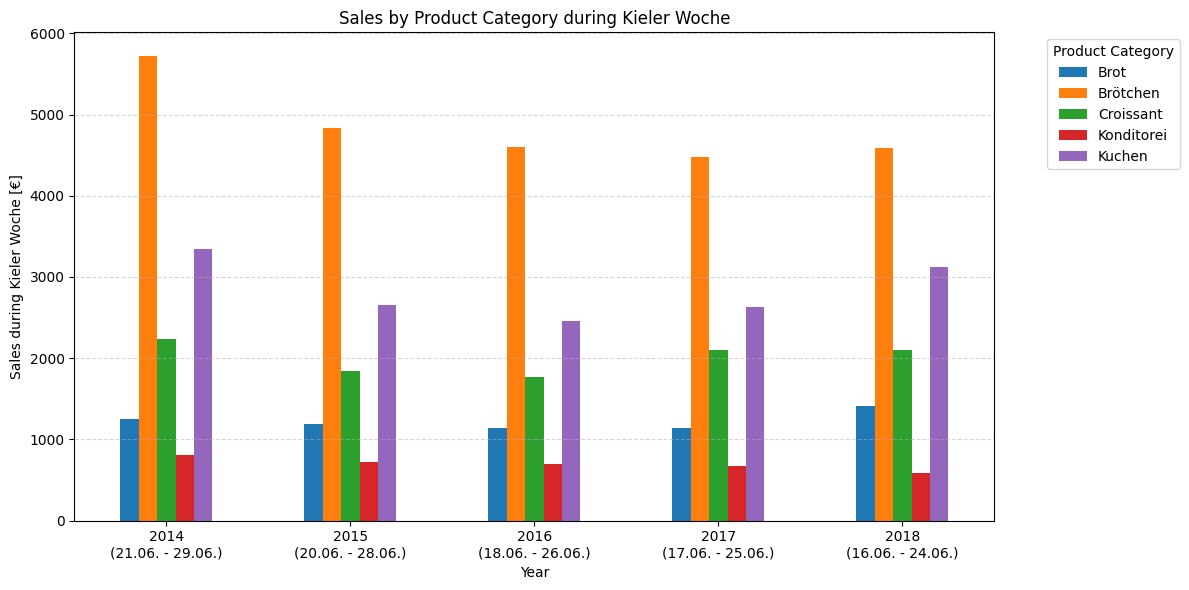

In [63]:
# Filter sales for Kieler Woche days
kielerwoche_sales = df[df['KielerWoche'] == 1].copy()

# Add year column
kielerwoche_sales['Year'] = kielerwoche_sales['Datum'].dt.year

# Find the min and max date for each year where Kieler Woche took place
kiwo_dates = kielerwoche_sales.groupby('Year')['Datum'].agg(['min', 'max']).reset_index()
kiwo_dates['label'] = kiwo_dates['Year'].astype(str) + "\n(" + kiwo_dates['min'].dt.strftime('%d.%m.') + " - " + kiwo_dates['max'].dt.strftime('%d.%m.') + ")"

# Group by year and product category, sum sales
kielerwoche_grouped = kielerwoche_sales.groupby(['Year', 'Warengruppe'])['Umsatz'].sum().reset_index()
kielerwoche_grouped['Warengruppe_Name'] = kielerwoche_grouped['Warengruppe'].map(warengruppe_mapping)

# Pivot for plotting
pivot_kw = kielerwoche_grouped.pivot(index='Year', columns='Warengruppe_Name', values='Umsatz')

# Prepare x-tick labels with year and KiWo dates
xtick_labels = kiwo_dates.set_index('Year').loc[pivot_kw.index]['label']

# Plot as grouped bar chart
ax = pivot_kw.plot(kind='bar', figsize=(12, 6))
ax.set_ylabel('Sales during Kieler Woche [€]')
ax.set_title('Sales by Product Category during Kieler Woche')
ax.set_xticklabels(xtick_labels)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Days with 0 Sales but no holiday

In [64]:
# Find every date where Umsatz is NaN but it is not a holiday, between 01.07.2013 and 01.08.2018

# Define date range
start_date = pd.Timestamp('2013-07-01')
end_date = pd.Timestamp('2018-08-01')

# Get all holiday dates as a set for fast lookup
holiday_set = set(holidays['Datum'])

# Filter for Umsatz is NaN, not a holiday, and within the date range
nan_sales_no_holiday = df[
    (df['Umsatz'].isna()) &
    (~df['Datum'].isin(holiday_set)) &
    (df['Datum'] >= start_date) &
    (df['Datum'] <= end_date)
][['Datum', 'Umsatz']]

print(nan_sales_no_holiday)

          Datum  Umsatz
1334 2013-12-28     NaN
1947 2014-05-03     NaN
1948 2014-05-04     NaN
2462 2014-08-17     NaN
5445 2016-03-24     NaN
5960 2016-07-07     NaN
6011 2016-07-18     NaN
6141 2016-08-14     NaN
6142 2016-08-15     NaN
6795 2016-12-17     NaN
7775 2017-07-04     NaN
8316 2017-10-23     NaN
9750 2018-08-01     NaN
